In [1]:
!python --version

Python 3.7.10


In [2]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO
import matplotlib.pyplot as plt


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [3]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdchem
from rdkit.Chem import Draw

import re


In [4]:
!pip install mordred

     |████████████████████████████████| 133kB 6.8MB/s 
  Created wheel for mordred: filename=mordred-1.2.0-cp37-none-any.whl size=176721 sha256=62038b4a5319f155f7d9491b0f8e0a77d44bb8db6519bfd7108986dab38a303d
  Stored in directory: /root/.cache/pip/wheels/ac/74/3f/2fd81b1187013f2eadb15620434813f1824c4c03b7bd1f94f6
Successfully built mordred


# feature.py code

In [5]:
# Credit: http://www.dna.bio.keio.ac.jp/smiles/

#import numpy as np
#import cupy as cp
#import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdchem
#from rdkit.Chem import AllChem
import re

# xp = np

#
Chiral = {"CHI_UNSPECIFIED":0,  "CHI_TETRAHEDRAL_CW":1, "CHI_TETRAHEDRAL_CCW":2, "CHI_OTHER":3}
Hybridization = {"UNSPECIFIED":0, "S":1, "SP":2, "SP2":3, "SP3":4, "SP3D":5, "SP3D2":6, "OTHER":7}

 # featurevector
atomInfo = 21
structInfo = 21
lensize= atomInfo + structInfo

H_Vector = [0]*atomInfo
H_Vector[0]= 1

#
lowerReg = re.compile(r'^[a-z]+$')
def islower(s):
    return lowerReg.match(s) is not None

#
upperReg = re.compile(r'^[A-Z]+$')
def isupper(s):
    return upperReg.match(s) is not None

#
def calc_atom_feature(atom):
    
    if atom.GetSymbol() == 'H':   feature = [1,0,0,0,0]
    elif atom.GetSymbol() == 'C': feature = [0,1,0,0,0]
    elif atom.GetSymbol() == 'O': feature = [0,0,1,0,0]
    elif atom.GetSymbol() == 'N': feature = [0,0,0,1,0]
    else: feature = [0,0,0,0,1]
        
    feature.append(atom.GetTotalNumHs()/8)
    feature.append(atom.GetTotalDegree()/4)
    feature.append(atom.GetFormalCharge()/8)
    feature.append(atom.GetTotalValence()/8)
    feature.append(atom.IsInRing()*1)
    feature.append(atom.GetIsAromatic()*1)

    f =  [0]*(len(Chiral)-1)
    if Chiral.get(str(atom.GetChiralTag()), 0) != 0:
        f[Chiral.get(str(atom.GetChiralTag()), 0)] = 1
    feature.extend(f)

    f =  [0]*(len(Hybridization)-1)
    if Hybridization.get(str(atom.GetHybridization()), 0) != 0:
        f[Hybridization.get(str(atom.GetHybridization()), 0)] = 1
    feature.extend(f)
    
    return(feature)


def calc_structure_feature(c,flag,label):
    feature = [0]*structInfo

    if c== '(' :
        feature[0] = 1
        flag = 0
    elif c== ')' :
        feature[1] = 1
        flag = 0
    elif c== '[' :
        feature[2] = 1
        flag = 0
    elif c== ']' :
        feature[3] = 1
        flag = 0
    elif c== '.' :
        feature[4] = 1
        flag = 0
    elif c== ':' :
        feature[5] = 1
        flag = 0
    elif c== '=' :
        feature[6] = 1
        flag = 0
    elif c== '#' :
        feature[7] = 1
        flag = 0
    elif c== '\\':
        feature[8] = 1
        flag = 0
    elif c== '/' :
        feature[9] = 1
        flag = 0  
    elif c== '@' :
        feature[10] = 1
        flag = 0
    elif c== '+' :
        feature[11] = 1
        flag = 1
    elif c== '-' :
        feature[12] = 1
        flag = 1
    elif c.isdigit() == True:
        if flag == 0:
            if c in label:
                feature[20] = 1
            else:
                label.append(c)
                feature[19] = 1
        else:
            feature[int(c)-1+12] = 1
            flag = 0
    return(feature,flag,label)


def calc_featurevector(mol, smiles,atomsize):
    flag = 0
    label = []
    molfeature=[]
    idx = 0
    j = 0
            
    for c in smiles:
        if islower(c) == True: continue
        elif isupper(c) == True:
            if c == 'H':
                molfeature.extend(H_Vector)
            else:
                molfeature.extend(calc_atom_feature(rdchem.Mol.GetAtomWithIdx(mol, idx)))
                idx = idx + 1
            molfeature.extend([0]*structInfo)
            j = j +1
            
        else:   
            molfeature.extend([0]*atomInfo)
            f,flag,label = calc_structure_feature(c,flag,label)
            molfeature.extend(f)
            j = j +1

    #0-Padding
    molfeature.extend([0]*(atomsize-j)*lensize)        
    return(molfeature)


def mol_to_feature(mol,n,atomsize):
    try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(n))
    except: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True)
    try: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(n))
    except: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True)
    return calc_featurevector(Chem.MolFromSmiles(defaultSMILES), isomerSMILES,atomsize)

def mol_to_allSMILESfeature(mol, atomsize):
    idx, features =0,  []
    while idx < mol.GetNumAtoms():
        try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(idx))
        except: break
        isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(idx))
        features.append(calc_featurevector(Chem.MolFromSmiles(defaultSMILES), isomerSMILES,atomsize))
        idx = idx + 1
    return(features)


def atom_flag(smiles,atomsize):
    flag=[]
    j = 0
            
    for c in smiles:
        if islower(c) == True: 
            if c in ['c', 'n', 's', 'o']:
                flag.append(1)
            else:
                flag.append(0)
        elif isupper(c) == True:
            if c in ['H',]:
                flag.append(0)
            else:
                flag.append(1)
        else:   
            flag.append(0)           

    #0-Padding
    flag.extend([0]*(atomsize-len(smiles)))        
    return(flag)

In [6]:
from tqdm import tqdm
from rdkit import Chem
import numpy as np
import pandas as pd
import pickle
from mordred import Calculator, descriptors

# Import dataset

In [7]:
!gdown --id 1EM5skz4TfnLk3JZSt-tKKadYFoPeYty7

Downloading...
From: https://drive.google.com/uc?id=1EM5skz4TfnLk3JZSt-tKKadYFoPeYty7
To: /content/SF17_ViralChEMBL_dataset.csv
251MB [00:02, 113MB/s]


In [8]:
db = pd.read_csv('SF17_ViralChEMBL_dataset.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
db.head(10)

,activity_id,standard_type,standard_relation,standard_value,standard_units,av_value,av_units,av_act50,assay_chembl_id,description,assay_type,findec_a,mapping_conf,stdstr_id,molregno,canonical_smiles,std_smiles,species_id,species_name,path_flag,genus_name,subfamily_name,family_name,order_name
0,147811,CC50,=,1000000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397206,1633264,CC1=CN([C@H]2C[C@H](O[N+](=O)[O-])[C@@H](CO)O2...,CC1=CN([C@H]2C[C@H](O[N+]([O-])=O)[C@@H](CO)O2...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
1,158768,CC50,=,200000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397576,1633676,NC1=NC(=O)N(C=C1)[C@H]2C[C@H](O[N+](=O)[O-])[C...,NC1=NC(=O)N(C=C1)[C@H]1C[C@H](O[N+]([O-])=O)[C...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
2,161153,CC50,=,700000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,166147,556,[O-][N+](=O)O[C@H]1CO[C@@H]2[C@@H](CO[C@H]12)O...,[O-][N+](=O)O[C@@H]1CO[C@@H]2[C@H](CO[C@H]12)O...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
3,162405,CC50,=,100000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,230956,82983,OC[C@H]1O[C@H](C[C@@H]1O)N2C=C(F)C(=O)NC2=O,OC[C@H]1O[C@H](C[C@@H]1O)N1C=C(F)C(=O)NC1=O,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
4,164805,CC50,=,21000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397165,1633207,O[C@H]1C[C@@H](O[C@@H]1CO[N+](=O)[O-])N2C=C(I)...,O[C@H]1C[C@@H](O[C@@H]1CO[N+]([O-])=O)N1C=C(I)...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
5,166047,CC50,=,74000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397575,1633675,OC[C@H]1O[C@H](C[C@@H]1O[N+](=O)[O-])N2C=C(F)C...,OC[C@H]1O[C@H](C[C@@H]1O[N+]([O-])=O)N1C=C(F)C...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
6,166058,CC50,=,7400000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,203297,47675,OC[C@H]1O[C@H](C[C@@H]1O)N2C=C(I)C(=O)NC2=O,OC[C@H]1O[C@H](C[C@@H]1O)N1C=C(I)C(=O)NC1=O,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
7,151529,CC50,=,850000.0,nM,NaN,NaN,NaN,CHEMBL615127,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397164,1633206,OC[C@H]1O[C@H](C[C@@H]1O[N+](=O)[O-])N2C=CC(=O...,OC[C@H]1O[C@H](C[C@@H]1O[N+]([O-])=O)N1C=CC(=O...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
8,158813,CC50,=,200000.0,nM,NaN,NaN,NaN,CHEMBL615127,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397210,1633268,NC1=NC(=O)N(C=C1I)[C@H]2C[C@H](O[N+](=O)[O-])[...,NC1=NC(=O)N(C=C1I)[C@H]1C[C@H](O[N+]([O-])=O)[...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
9,161189,CC50,=,410000.0,nM,NaN,NaN,NaN,CHEMBL615127,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397552,1633652,OC[C@H]1O[C@H](C[C@@H]1O[N+](=O)[O-])N2C=C(I)C...,OC[C@H]1O[C@H](C[C@@H]1O[N+]([O-])=O)N1C=C(I)C...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales


# HIV-1/HIV-2

In [10]:
HIV1 = 2938
HIV2 = 2939

In [11]:
hiv1_ds = db[(db.species_id == HIV1) & (db.av_act50.notna())]

In [12]:
# we have some sources, where av_act50 can be both 0 and 1
(hiv1_ds.groupby(['assay_chembl_id', 'molregno']).av_act50.nunique() > 1).sum()

56

In [13]:
# in these sources, the molecule is the same
hiv1_assays_data = hiv1_ds.groupby(['assay_chembl_id', 'molregno'])[['av_act50', 'canonical_smiles']].nunique() 
hiv1_assays_data[hiv1_assays_data.av_act50 > 1]

av_act50  canonical_smiles
assay_chembl_id molregno                            
CHEMBL1004248   465352           2                 1
CHEMBL1033994   132377           2                 1
CHEMBL1108869   619344           2                 1
CHEMBL1685113   1072061          2                 1
CHEMBL1686816   1072268          2                 1
CHEMBL1831786   27307            2                 1
CHEMBL2114836   826304           2                 1
                857546           2                 1
                991212           2                 1
                1413500          2                 1
CHEMBL2169594   1427232          2                 1
                1427239          2                 1
CHEMBL653896    1386795          2                 1
CHEMBL656774    1386795          2                 1
CHEMBL659220    93844            2                 1
CHEMBL683470    858              2                 1
                211835           2                 1
CHEMBL683828    241857           2                 1
                322589           2                 1
                322590           2                 1
                519395           2                 1
                1387258          2                 1
                1387259          2                 1
CHEMBL688519    2127             2                 1
CHEMBL689125    44003            2                 1
CHEMBL691374    210170           2                 1
CHEMBL691375    209873           2                 1
CHEMBL691959    194308           2                 1
CHEMBL692262    132486           2                 1
CHEMBL692940    2127             2                 1
CHEMBL699301    72977            2                 1
                73699            2                 1
                73772            2                 1
CHEMBL701116    132379           2                 1
                132543           2                 1
CHEMBL701718    132042           2                 1
                132073           2                 1
                132543           2                 1
                133032           2                 1
CHEMBL702112    269683           2                 1
CHEMBL711808    1632053          2                 1
                1632493          2                 1
CHEMBL712341    194308           2                 1
CHEMBL713267    65494            2                 1
CHEMBL765299    295745           2                 1
CHEMBL769358    190647           2                 1
CHEMBL800045    27307            2                 1
CHEMBL804233    507934           2                 1
                1368022          2                 1
                1368023          2                 1
                1368024          2                 1
CHEMBL854584    355030           2                 1
CHEMBL854586    355030           2                 1
CHEMBL876242    1386711          2                 1
CHEMBL884233    2127             2                 1
CHEMBL918147    374732           2                 1

In [14]:
# the ratio is small, so I'll drop them
hiv1_assays_data[hiv1_assays_data.av_act50 > 1].shape[0] / hiv1_assays_data.shape[0]

0.0006316050663749252

In [15]:
for (chembl_id, mol) in (hiv1_assays_data[hiv1_assays_data.av_act50 > 1]).index.values:
    hiv1_ds = hiv1_ds[~((hiv1_ds.assay_chembl_id == chembl_id) & (hiv1_ds.molregno == mol))]

In [16]:
# all gone!
(hiv1_ds.groupby(['assay_chembl_id', 'molregno']).av_act50.nunique() > 1).sum()

0

In [17]:
hiv2_ds = db[(db.species_id == HIV2) & (db.av_act50.notna())]

In [18]:
# no controversial data for HIV2
(hiv2_ds.groupby(['assay_chembl_id', 'molregno']).av_act50.nunique() > 1).sum()

0

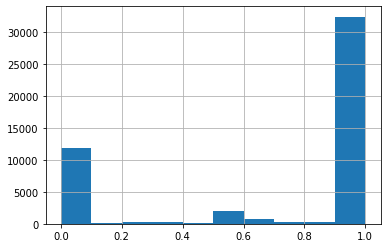

In [19]:
hiv1_ds.groupby('molregno').av_act50.mean().hist(bins=10)

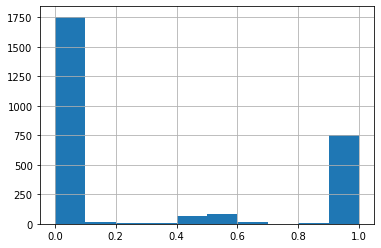

In [20]:
hiv2_ds.groupby('molregno').av_act50.mean().hist(bins=10)

In [21]:
hiv1_indices = hiv1_ds.groupby('molregno').av_act50.mean()[hiv1_ds.groupby('molregno').av_act50.mean() > 0.5].index.values
hiv2_indices = hiv2_ds.groupby('molregno').av_act50.mean()[hiv2_ds.groupby('molregno').av_act50.mean() > 0.5].index.values

In [22]:
hiv1_ds_final = hiv1_ds[hiv1_ds.molregno.isin(hiv1_indices)]
hiv2_ds_final = hiv2_ds[hiv2_ds.molregno.isin(hiv2_indices)]

In [23]:
hiv1_ds.molregno.nunique(), hiv2_ds.molregno.nunique()

(48553, 2700)

In [24]:
hiv1_ds_final.molregno.nunique(), hiv2_ds_final.molregno.nunique()

(33932, 775)

In [25]:
import matplotlib
from matplotlib_venn import venn2, venn2_circles

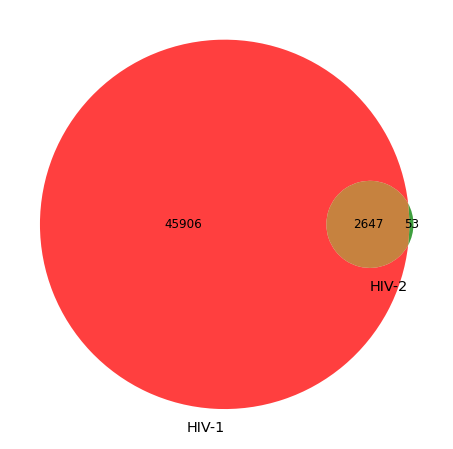

In [26]:
font = {'size'   : 12}
matplotlib.rc('font', **font)
plt.figure(figsize=(8,8))
out = venn2([set(hiv1_ds.molregno.values), set(hiv2_ds.molregno.values)], 
      # set_colors=('#3E64AF', '#3EAF5D'), 
      set_labels = ('HIV-1', 
                    'HIV-2'),
      alpha=0.75)
plt.show()

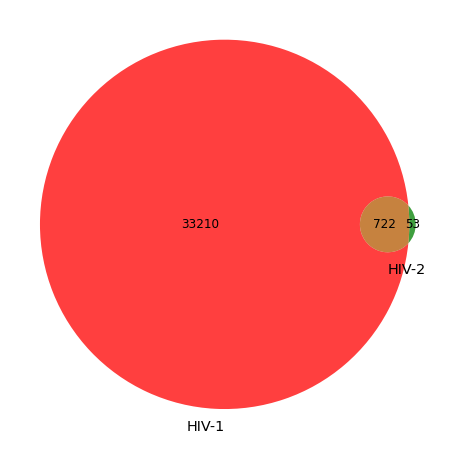

In [27]:
font = {'size'   : 12}
matplotlib.rc('font', **font)
plt.figure(figsize=(8,8))
out = venn2([set(hiv1_ds_final.molregno.values), set(hiv2_ds_final.molregno.values)], 
      # set_colors=('#3E64AF', '#3EAF5D'), 
      set_labels = ('HIV-1', 
                    'HIV-2'),
      alpha=0.75)
plt.show()

# HIV-1/HCV

In [28]:
HCV = 1620

In [29]:
hcv_ds = db[(db.species_id == HCV) & (db.av_act50.notna())]

In [30]:
(hcv_ds.groupby(['assay_chembl_id', 'molregno']).av_act50.nunique() > 1).sum()

71

In [31]:
# ratio of controversial assays
hcv_assays_data = hcv_ds.groupby(['assay_chembl_id', 'molregno'])[['av_act50', 'canonical_smiles']].nunique()
hcv_assays_data[hcv_assays_data.av_act50 > 1].shape[0] / hcv_assays_data.shape[0]

0.000735020083647356

In [32]:
for (chembl_id, mol) in (hcv_assays_data[hcv_assays_data.av_act50 > 1]).index.values:
    hcv_ds = hcv_ds[~((hcv_ds.assay_chembl_id == chembl_id) & (hcv_ds.molregno == mol))]

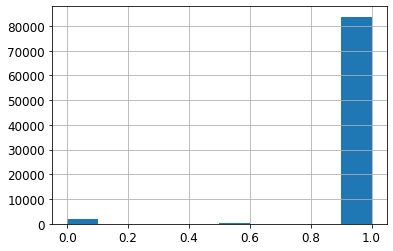

In [33]:
hcv_ds.groupby('molregno').av_act50.mean().hist(bins=10)

In [34]:
hcv_indices = hcv_ds.groupby('molregno').av_act50.mean()[hcv_ds.groupby('molregno').av_act50.mean() > 0.5].index.values
hcv_ds_final = hcv_ds[hcv_ds.molregno.isin(hcv_indices)]

In [35]:
hiv1_ds_final.molregno.nunique(), hcv_ds_final.molregno.nunique()

(33932, 83938)

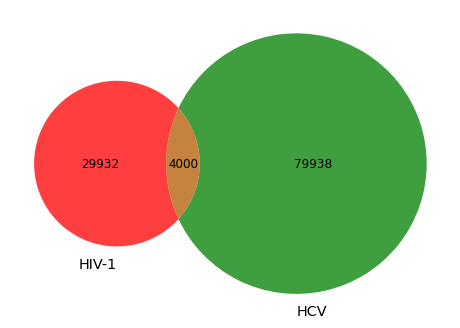

In [36]:
font = {'size'   : 12}
matplotlib.rc('font', **font)
plt.figure(figsize=(8,8))
out = venn2([set(hiv1_ds_final.molregno.values), set(hcv_ds_final.molregno.values)], 
      # set_colors=('#3E64AF', '#3EAF5D'), 
      set_labels = ('HIV-1', 
                    'HCV'),
      alpha=0.75)
plt.show()

# Datasets


In [46]:
hiv1_hcv = pd.concat([hiv1_ds_final[['canonical_smiles', 'species_id']].drop_duplicates(),
                      hcv_ds_final[['canonical_smiles', 'species_id']].drop_duplicates()])


In [47]:
intersec = hiv1_hcv.groupby('canonical_smiles').species_id.nunique()
intersec = intersec[intersec > 1]

In [48]:
hiv1_hcv = hiv1_hcv[~hiv1_hcv.canonical_smiles.isin(intersec.index.values)]

In [49]:
hiv1_hcv.canonical_smiles.apply(len).max()

1966

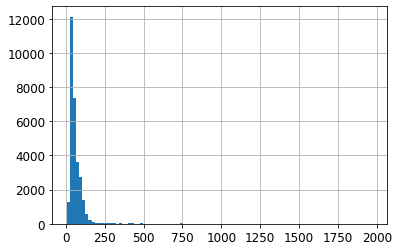

In [50]:
# HIV-1 molecules length distribution
hiv1_hcv[hiv1_hcv.species_id == HIV1].canonical_smiles.apply(len).hist(bins=100)

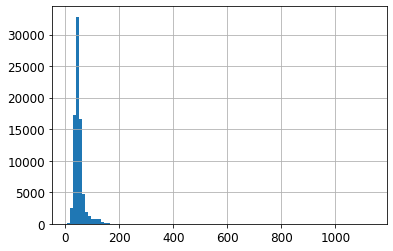

In [51]:
# HCV molecules length distribution
hiv1_hcv[hiv1_hcv.species_id == HCV].canonical_smiles.apply(len).hist(bins=100)

In [52]:
MAX_LEN = 250
DEBUG = False

In [53]:
hiv1_hcv = hiv1_hcv[hiv1_hcv.canonical_smiles.apply(len) < MAX_LEN]

In [59]:
!gdown --id 16S-QJGH0vWtmhB0ONF0cFyyoNmObusd8

Downloading...
From: https://drive.google.com/uc?id=16S-QJGH0vWtmhB0ONF0cFyyoNmObusd8
To: /content/mord_keys.csv
100% 6.21k/6.21k [00:00<00:00, 2.34MB/s]


In [60]:
custom_descriptors = pd.read_csv('mord_keys.csv')['mord_keys'].values.tolist()

In [44]:
# !!!the following code can take a long time and a lot of memory 
# running on subset 

In [54]:
hiv1_hcv = hiv1_hcv.head(200) # comment this line to get a full dataset

In [63]:
mols = [Chem.MolFromSmiles(i) for i in hiv1_hcv.canonical_smiles]
calc = Calculator(descriptors, ignore_3D=True)

In [65]:
md = calc.pandas(mols)

 18%|█▊        | 36/200 [00:27<03:06,  1.14s/it]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 44%|████▎     | 87/200 [01:06<01:30,  1.25it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 200/200 [02:21<00:00,  1.41it/s]


In [66]:
smile_ft = [mol_to_feature(mol,-1, MAX_LEN) for mol in mols]

In [67]:
md = md[custom_descriptors]

In [68]:
md['active'] = hiv1_hcv.species_id.apply(lambda x: 1 if x == HIV1 else 0).values.tolist()
md['smile_ft'] = smile_ft
md['smiles'] = hiv1_hcv.canonical_smiles.values.tolist()

In [69]:
md.to_csv('hiv1_hcv_temp.csv', index=False)
hiv1_hcv_final = pd.read_csv('hiv1_hcv_temp.csv')

In [73]:
# when working with full dataset, reading hiv1_hcv_final will return you warning
# DtypeWarning: Columns (4,5,6, ...) have mixed types. Specify dtype option on import or set low_memory=False.
# copy all the listed columns to bad_cols list 
bad_cols = []

In [74]:
for c in bad_cols:
    col = hiv1_hcv_final.columns.values[c]
    # col contains numbers and string - the error message
    # taking max value will return you this error message
    bad_val = max(hiv1_hcv_final[col].apply(str).values)
    to_drop = hiv1_hcv_final[hiv1_hcv_final[col] == bad_val].index.values.tolist()
    hiv1_hcv_final = hiv1_hcv_final.drop(to_drop, axis=0)

In [75]:
hiv1_hcv_final.to_csv('hiv1_hcv.csv', index=False)